In [1]:
# 모듈 & 라이브러리 로드
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# 최근 1년 환율 데이터셋 로드
usd_krw = pd.read_csv('./USD_KRW_Rec1Y.csv')
jpy_krw = pd.read_csv('./JPY_KRW_Rec1Y.csv')
eur_krw = pd.read_csv('./EUR_KRW_Rec1Y.csv')
cny_krw = pd.read_csv('./CNY_KRW_Rec1Y.csv')
gbp_krw = pd.read_csv('./GBP_KRW_Rec1Y.csv')

In [3]:
# 데이터 정제
def clean_data(df):
    #'날짜(date)' Column
    if df['날짜'].dtype == 'object': #
        df['날짜'] = pd.to_datetime(df['날짜'].str.strip()) #날짜형식 개체변환 및 빈공간 거거
    #'종가(Closing Price)' Column
    if df['종가'].dtype == 'object':
        df['종가'] = df['종가'].str.replace(',', '').astype(float) #콤마 제거 및 Float 변환
    return df[['날짜', '종가']]

In [4]:
usd_krw_clean = clean_data(usd_krw)
jpy_krw_clean = clean_data(jpy_krw)
eur_krw_clean = clean_data(eur_krw)
cny_krw_clean = clean_data(cny_krw)
gbp_krw_clean = clean_data(gbp_krw)

In [5]:
# 날짜(date)를 기반으로 컬럼 병합
data_merged = pd.merge(usd_krw_clean, jpy_krw_clean, on='날짜', suffixes=('_USD', '_JPY'))
data_merged = pd.merge(data_merged, eur_krw_clean, on='날짜')
data_merged = pd.merge(data_merged, cny_krw_clean, on='날짜', suffixes=('_EUR', '_CNY'))
data_merged = pd.merge(data_merged, gbp_krw_clean, on='날짜', suffixes=('_GBP', '_KRW'))

data_merged.columns = ['Date', 'USD_KRW', 'JPY_KRW', 'EUR_KRW', 'CNY_KRW', 'GBP_KRW']
data_merged.head()

,Date,USD_KRW,JPY_KRW,EUR_KRW,CNY_KRW,GBP_KRW
0,2024-04-30,1385.38,8.7788,1477.37,191.30,1730.48
1,2024-04-29,1374.67,8.7928,1473.51,190.07,1726.72
2,2024-04-26,1376.43,8.6923,1471.68,189.94,1719.02
3,2024-04-25,1371.41,8.8103,1471.39,189.41,1716.05
4,2024-04-24,1377.03,8.8640,1473.01,190.04,1715.92


In [6]:
# 결측치 확인
data_merged.isnull().sum()

Date       0
USD_KRW    0
JPY_KRW    0
EUR_KRW    0
CNY_KRW    0
GBP_KRW    0
dtype: int64

In [7]:
# 독립 (엔, 유로, 위안, 파운드)
X = data_merged[['JPY_KRW', 'EUR_KRW', 'CNY_KRW', 'GBP_KRW']]
# 종속 (달러)
y = data_merged['USD_KRW']

# 상수항 추가
X = sm.add_constant(X)

# OLS Model
model = sm.OLS(y, X).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                USD_KRW   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     227.7
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           3.41e-83
Time:                        17:02:05   Log-Likelihood:                -1023.1
No. Observations:                 262   AIC:                             2056.
Df Residuals:                     257   BIC:                             2074.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        376.0500     58.903      6.384      0.000     260.057     492.043
JPY_KRW      -43.0814      3.546    -12.150      0.000     -50.064     -36.099
EUR_KRW        0.1338      0.112      1.193      0.234      -0.087       0.355
CNY_KRW        6.2564      0.360     17.363      0.000       5.547       6.966
GBP_KRW       -0.0029      0.067     -0.044      0.965      -0.134       0.128
==============================================================================
Omnibus:                       12.102   Durbin-Watson:                   0.097
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               10.103
Skew:                           0.397   Prob(JB):                      0.00640
Kurtosis:                       2.457   Cond. No.                     1.73e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

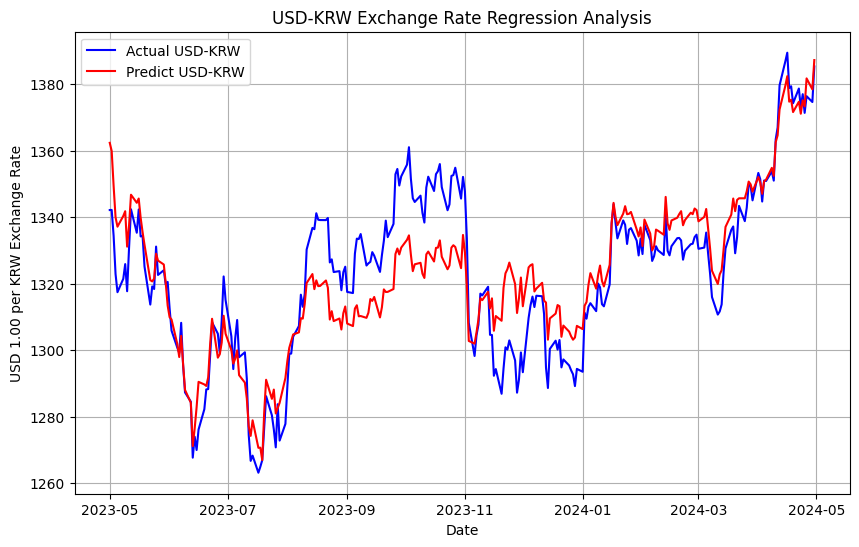

In [8]:
# 시간변화에 따른 회귀분석 결과 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(data_merged['Date'], data_merged['USD_KRW'], color='blue', label='Actual USD-KRW') #실제환율
plt.plot(data_merged['Date'], model.fittedvalues, color='red', label='Predict USD-KRW') #예측환율
plt.xlabel('Date')
plt.ylabel('USD 1.00 per KRW Exchange Rate')
plt.title('USD-KRW Exchange Rate Regression Analysis')
plt.legend()
plt.grid(True)
plt.show()

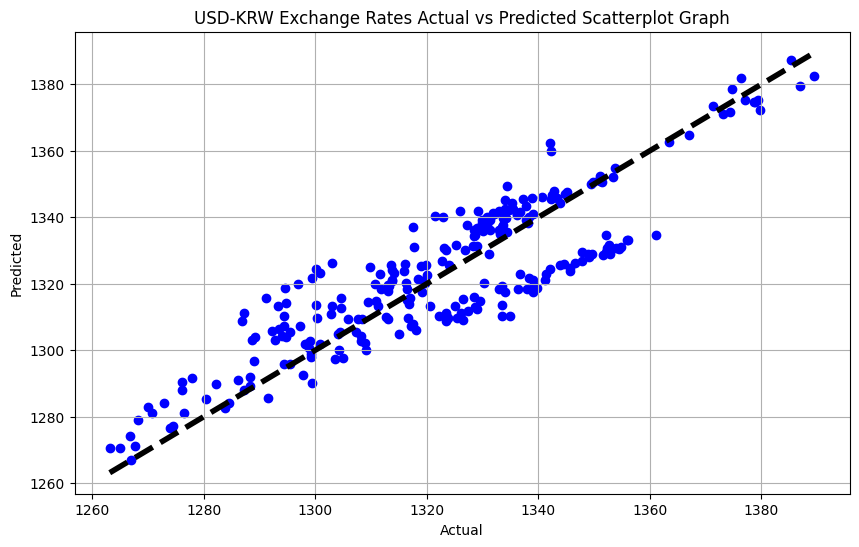

In [9]:
# 실제 값과 예측 값 산점도 확인
plt.figure(figsize=(10, 6))
plt.scatter(data_merged['USD_KRW'], model.fittedvalues, color='blue')
plt.plot([data_merged['USD_KRW'].min(), data_merged['USD_KRW'].max()], [data_merged['USD_KRW'].min(), data_merged['USD_KRW'].max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('USD-KRW Exchange Rates Actual vs Predicted Scatterplot Graph')
plt.grid(True)
plt.show()

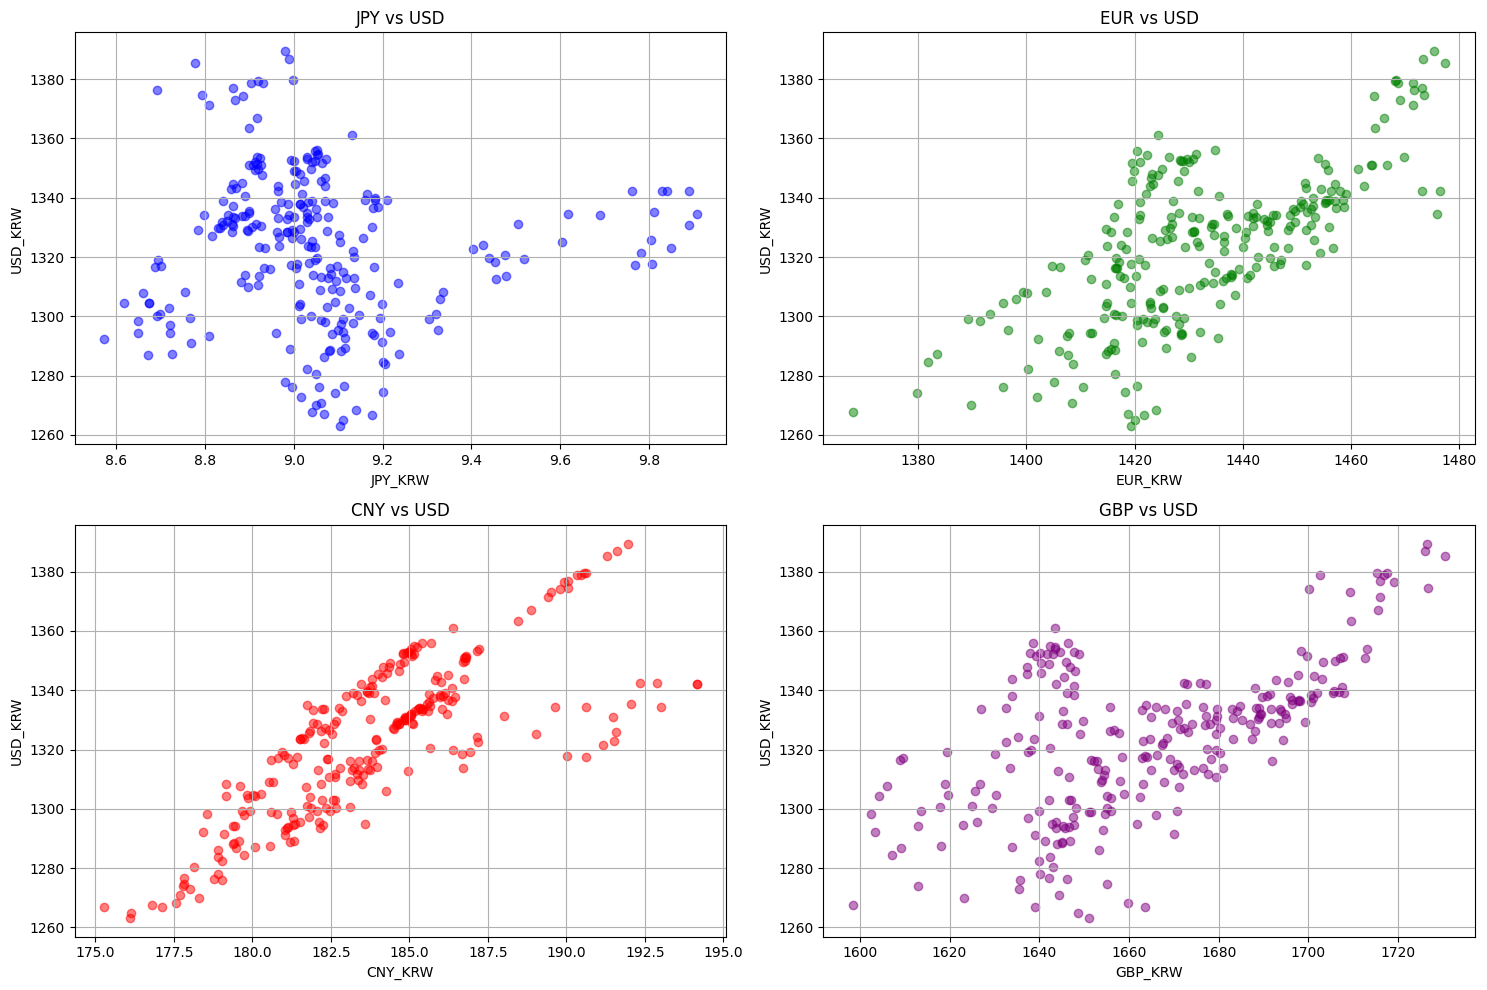

In [10]:
# SDR-USD-KRW간 회귀분석 개별결과
variables = ['JPY_KRW', 'EUR_KRW', 'CNY_KRW', 'GBP_KRW']
colors = ['blue', 'green', 'red', 'purple']
titles = ['JPY vs USD', 'EUR vs USD', 'CNY vs USD', 'GBP vs USD']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for i, variable in enumerate(variables):
    axs[i].scatter(data_merged[variable], data_merged['USD_KRW'], color=colors[i], alpha=0.5)
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel('USD_KRW')
    axs[i].set_title(titles[i])
    axs[i].grid(True)

plt.tight_layout()
plt.show()

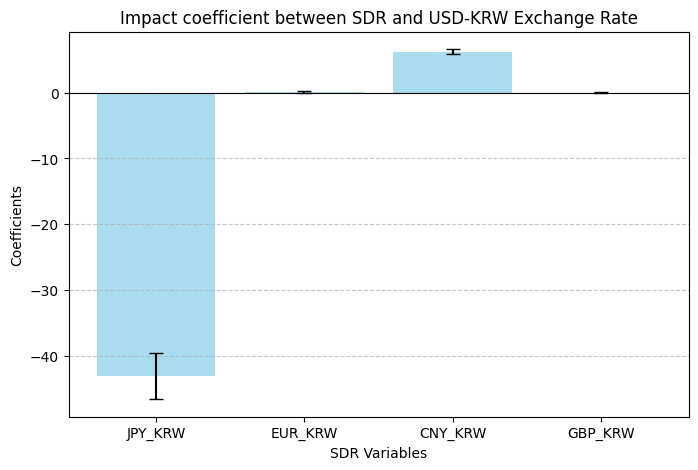

In [11]:
# 계수 및 표준 오차 추출
coefficients = model.params[1:]  # 계수 추출
standard_errors = model.bse[1:]  # 표준 차차
variables = coefficients.index

# SDR과 USD-KRW 간 상관관계 시각화
plt.figure(figsize=(8, 5))
plt.bar(variables, coefficients, yerr=standard_errors, color='skyblue', alpha=0.7, capsize=5)
plt.xlabel('SDR Variables')
plt.ylabel('Coefficients')
plt.title('Impact coefficient between SDR and USD-KRW Exchange Rate')
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()